In [1]:
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'


In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

In [3]:
from torchsummary import summary
import torch
use_cuda=torch.cuda.is_available()
import pytorch
from pytorch import dataset as ptd

import os
import datasets
import pytorch_models
import torch.optim as optim
dataset_name="mnist"
(x_train, y_train), (x_test, y_test), input_shape,num_classes = datasets.get_data(dataset_name)
dataset=ptd.ClassificationDataset(dataset_name,x_train,x_test,y_train,y_test,num_classes,input_shape)

print('x_train shape:', x_train.shape,x_train.dtype)
print('x_test shape:', x_test.shape,x_test.dtype)
print('y_train shape:', y_train.shape,y_train.dtype)
print('y_test shape:', y_test.shape,y_test.dtype)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


import numpy as np
print(np.unique(y_train.argmax(axis=1)))
print(y_train.min(),y_train.max())


Using TensorFlow backend.
/home/facundo/.python/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


x_train shape: (60000, 28, 28, 1) uint8
x_test shape: (10000, 28, 28, 1) uint8
y_train shape: (60000, 10) float64
y_test shape: (10000, 10) float64
60000 train samples
10000 test samples
[0 1 2 3 4 5 6 7 8 9]
0.0 1.0


In [4]:
from pytorch import training

import pytorch_models

conv_filters={"mnist":32,"mnist_rot":32,"cifar10":64}
fc_filters={"mnist":64,"mnist_rot":64,"cifar10":128}
model = pytorch_models.SimpleConv(input_shape,num_classes,
                                 conv_filters=conv_filters[dataset.name],fc_filters=fc_filters[dataset.name])
#model= pytorch_models.FFNet(input_shape,num_classes)x
if use_cuda:
    model=model.cuda()
parameters=training.add_weight_decay(model.named_parameters(),1e-9)
optimizer = optim.Adam(parameters, lr=0.001)
print(model)

rotated_model= pytorch_models.SimpleConv(input_shape,num_classes,
                                       conv_filters=conv_filters[dataset.name],fc_filters=fc_filters[dataset.name])
if use_cuda:
    rotated_model= rotated_model.cuda()
rotated_parameters=training.add_weight_decay(rotated_model.named_parameters(),1e-9)
rotated_optimizer = optim.Adam(rotated_parameters, lr=0.001)

print(rotated_model)
#summary(model, input_size=[1,28,28])


SimpleConv(
  (conv): SequentialWithIntermediates(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
  )
  (fc): SequentialWithIntermediates(
    (0): Linear(in_features=6272, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
SimpleConv(
  (conv): SequentialWithIntermediates(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(

Training model with unrotated dataset...


Epoch 1: 100% (batch 938/938)  ==stats==> loss:  0.139, accuracy:  0.957, Time:  0:00:05


Test => Loss: 0.0478, Accuracy: 98.57% (9857/10000)


Epoch 2: 100% (batch 938/938)  ==stats==> loss: 0.0417, accuracy:  0.987, Time:  0:00:05


Test => Loss: 0.0331, Accuracy: 98.97% (9897/10000)


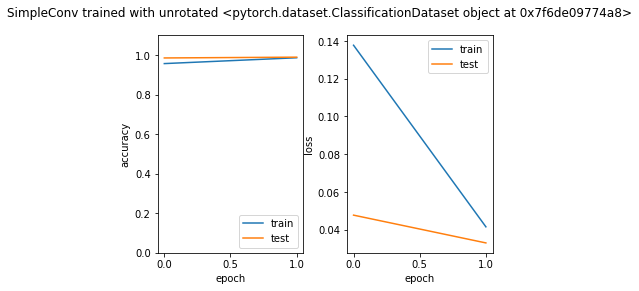

Skipping pretraining rotated model with unrotated dataset
Training rotated model with rotated dataset...


Epoch 1: 100% (batch 938/938)  ==stats==> loss:  0.511, accuracy:  0.829, Time:  0:00:07


Test => Loss: 0.2104, Accuracy: 93.08% (9308/10000)


Epoch 2: 100% (batch 938/938)  ==stats==> loss:  0.181, accuracy:  0.944, Time:  0:00:07


Test => Loss: 0.1418, Accuracy: 95.49% (9549/10000)


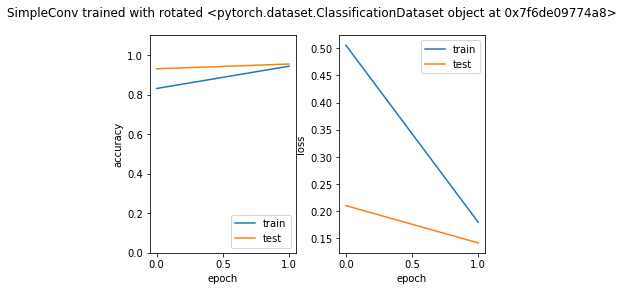

Testing both models on both datasets...


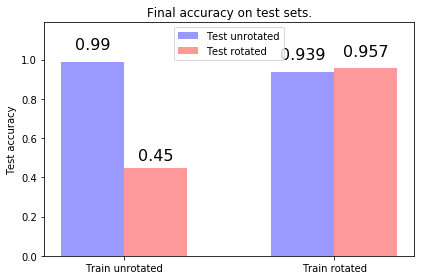

model_rotated_test_dataset score: loss=3.897308, accuracy=0.449700
model_rotated_train_dataset score: loss=3.919075, accuracy=0.441800
model_test_dataset score: loss=0.033071, accuracy=0.989700
model_train_dataset score: loss=0.026871, accuracy=0.991217
rotated_model_rotated_test_dataset score: loss=0.140208, accuracy=0.956800
rotated_model_rotated_train_dataset score: loss=0.145663, accuracy=0.954300
rotated_model_test_dataset score: loss=0.184331, accuracy=0.939100
rotated_model_train_dataset score: loss=0.188123, accuracy=0.941517


In [5]:
batch_size = 64

epochs={'cifar10':5,'mnist':2,'fashion_mnist':12,'cluttered_mnist':10,'lsa16':15,'mnist_rot':5,'pugeault':15}
from pytorch.experiment import rotation
rotated_epochs={'cifar10':100,'mnist':2,'fashion_mnist':60,'cluttered_mnist':30,'lsa16':100,'mnist_rot':5,'pugeault':40}

config=pytorch.experiment.rotation.TrainRotatedConfig(dataset_name=dataset,batch_size=batch_size,
                   epochs=epochs[dataset.name],rotated_epochs=rotated_epochs[dataset.name],
                   pre_rotated_epochs=0, optimizer=optimizer,rotated_optimizer=rotated_optimizer,
                  use_cuda=use_cuda)

scores=rotation.run(config,model,rotated_model,
                                        x_train,y_train,x_test,y_test,plot_accuracy=True,save_plots=False)
for k,v in scores.items():
    print('%s score: loss=%f, accuracy=%f' % (k,v[0],v[1]))


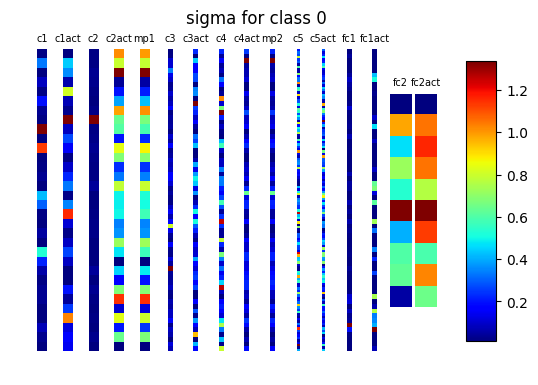

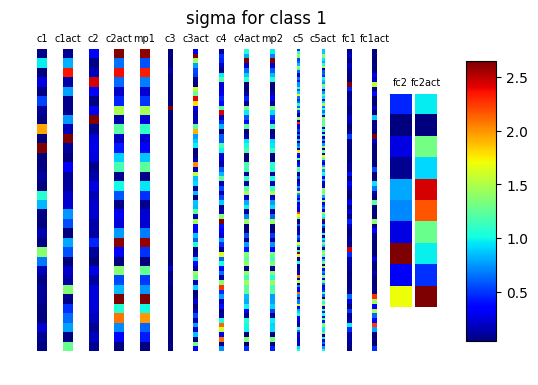

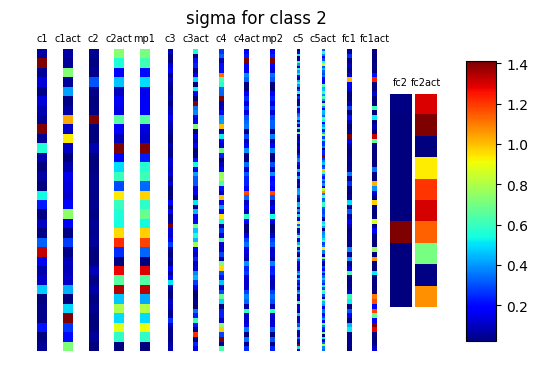

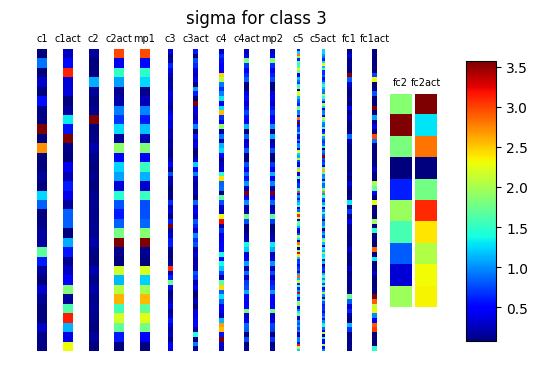

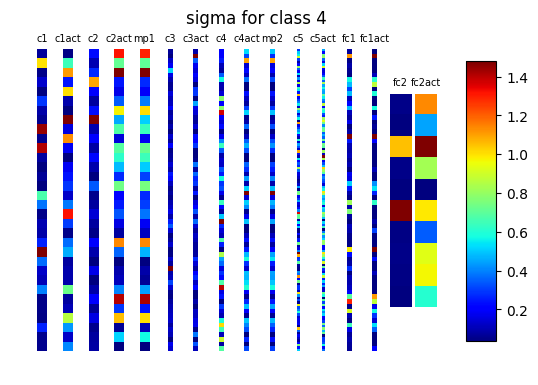

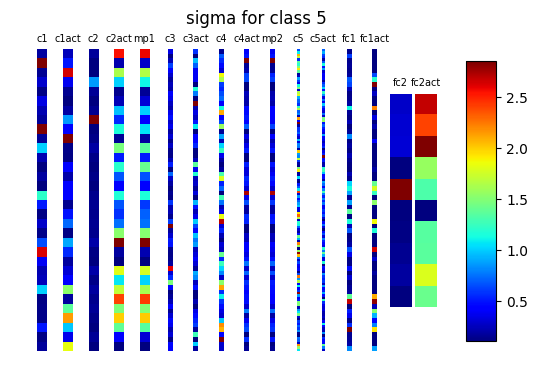

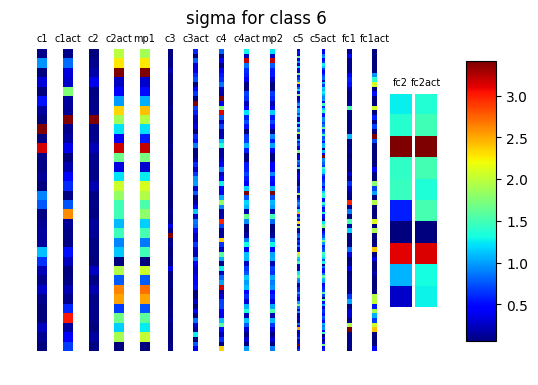

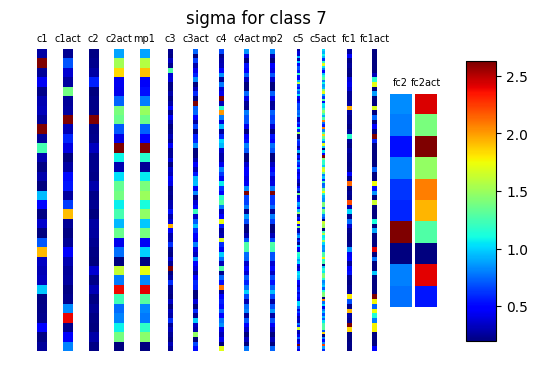

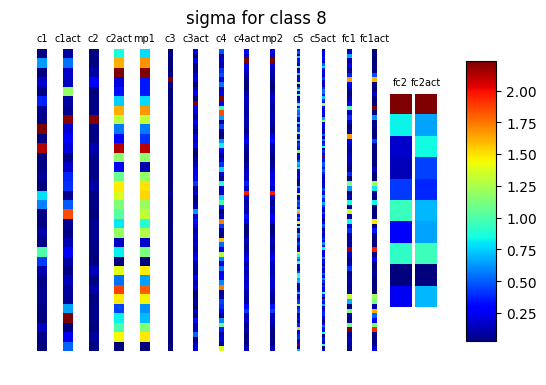

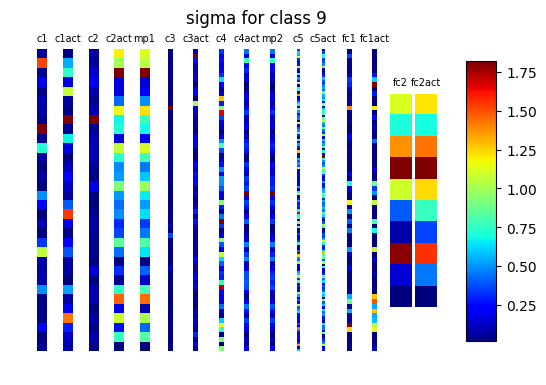

In [12]:
from pytorch.experiment import invariance
n_rotations=8

invariance.run(rotated_model,dataset,config)